# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [50]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1
1,1392518336,0
2,361208576,1
3,1535215357,1
4,4396196375,1


In [ ]:
df_users_train

In [29]:
?head()

Object `head` not found.


In [48]:
df_users['uid'][:10]

0             202388889
1            1392518336
2             361208576
3            1535215357
4            4396196375
5              17938477
6    720288026681716737
7             174004739
8              53783678
9             257662370
Name: uid, dtype: int64

Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

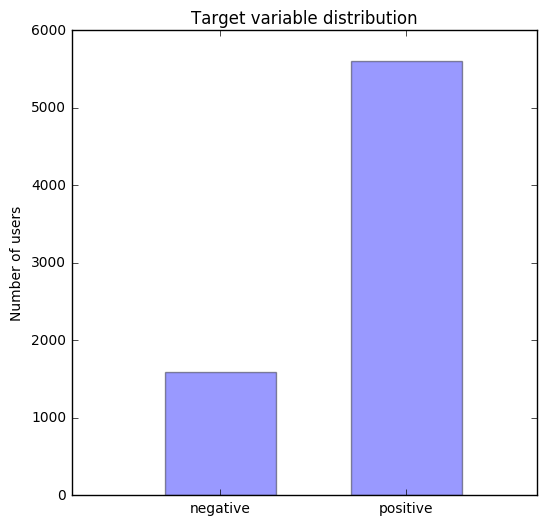

In [30]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0, 1, 2])
# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.6, alpha=0.4)
pl.xticks(bins[:-1]+0.3, ("negative", "positive"))
pl.xlim(bins[0]-0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

In [70]:
?pl.xticks()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [57]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [32]:
GEO_USER_NAME = "santamoniya"

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    # your code here
    params = dict(q=location, maxRows=1, username=GEO_USER_NAME)
    try:
        info = requests.get(url='http://api.geonames.org/searchJSON', params=params)
        loc = info.json()['geonames'][0]
        lng = loc['lng']
        lat = loc['lat']
        country = loc['countryName']
    except:
        lng = None
        lat = None
        country = None
    
    return (lng, lat, country)

In [25]:
get_coordinates_by_location('Astana')

(u'71.44598', u'51.1801', u'Kazakhstan')

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [60]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    r
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')

def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    # your code here
    result = []
    USERS_PER_REQUEST = 100
    NUMBER_OF_USERS = len(df['uid'])
    REQUESTS_NUMBER = NUMBER_OF_USERS / USERS_PER_REQUEST + 1
    for r in xrange(REQUESTS_NUMBER):
        # some_downloaded_user = get_user_from_api
        #get list of users ids
        ids_list = list(df['uid'][r * USERS_PER_REQUEST:(r + 1) * USERS_PER_REQUEST])
        #get users' records from twitter
        #print ids_list
        users = api.UsersLookup(user_id=ids_list)
        for user in users:
            record = twitter_user_to_dataframe_record(user)
            result.append(record)
        # also write user as json line in temporary file
            json.dump(obj=record, fp=f)
    return result

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


In [152]:
user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    print r
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')

In [23]:
?api.UsersLookup()

In [21]:
?json.dump()

In [61]:
f.close()

In [62]:
df_full[:10]

,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",-82.70343,27.74836,United States,2010-10,1050,1961,9481,21323,27
1,1392518336,0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,103.5269,1.5486,Malaysia,2013-04,1196,836,19288,7182,110
2,361208576,1,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",-2.23743,53.48095,United Kingdom,2011-08,633,577,7851,1141,28
3,1535215357,1,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,None,None,None,2013-06,2367,2436,187956,88057,68
4,4396196375,1,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awareness...,False,God is my refuge; gem❤️,None,None,None,2015-12,1252,970,36787,26993,75
5,17938477,1,Skelly & Mulder,SkellyScribbles,"visual artist, writer, and photographer.",False,"Richmond, VA",-77.46026,37.55376,United States,2008-12,334,500,5475,8038,56
6,720288026681716737,1,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",False,"Toronto, Ontario",-79.4163,43.70011,Canada,2016-04,67,70,9492,37,87
7,174004739,1,marc,_MightyMarc_,NaN,False,NaN,NaN,NaN,NaN,2010-08,370,1880,56385,132885,27
8,53783678,1,Lady Attis ⚦,ladyattis,Your friendly neighborhood androgynous android...,False,"Minneapolis, MN",-93.26384,44.97997,United States,2009-07,758,1079,39361,69635,52
9,257662370,1,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,False,"Seattle, WA",-122.33207,47.60621,United States,2011-02,766,1377,19243,9409,29


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

In [65]:
list(df_full['created_at'][:5])

['2010-10', '2013-04', '2011-08', '2013-06', '2015-12']

In [77]:
?pd.date_range('09/2006', '03/2016', freq='M')

In [ ]:
dts, pos, neg = [], [], []
for dt, group in df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"])):
    dts.append(dt)
    positive, negative = 0, 0
    cls = group['cls']
    for value in cls:
        if value == 1:
            positive += 1
        else:
            negative += 1
    pos.append(positive)
    neg.append(negative)
print pos, '\n', neg, '\n', dts

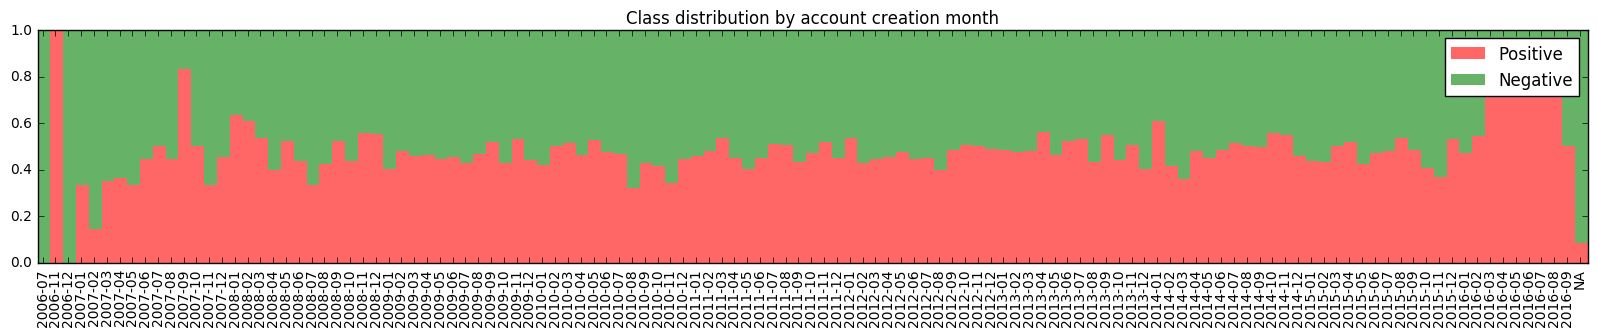

In [115]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts, count_pos, count_neg = [], [], []
    # your code here 
    for date, group in grouped:
        dts.append(date)
        positive, negative = 0, 0
        cls = group['cls']
        for value in cls:
            if value == 1:
                positive += 1
            else:
                negative += 1
        count_pos.append(float(positive))
        count_neg.append(float(negative))
        
    return np.array(count_pos), np.array(count_neg), dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

In [79]:
?df_full.groupby()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

CPU times: user 4.64 s, sys: 20 ms, total: 4.66 s
Wall time: 4.67 s


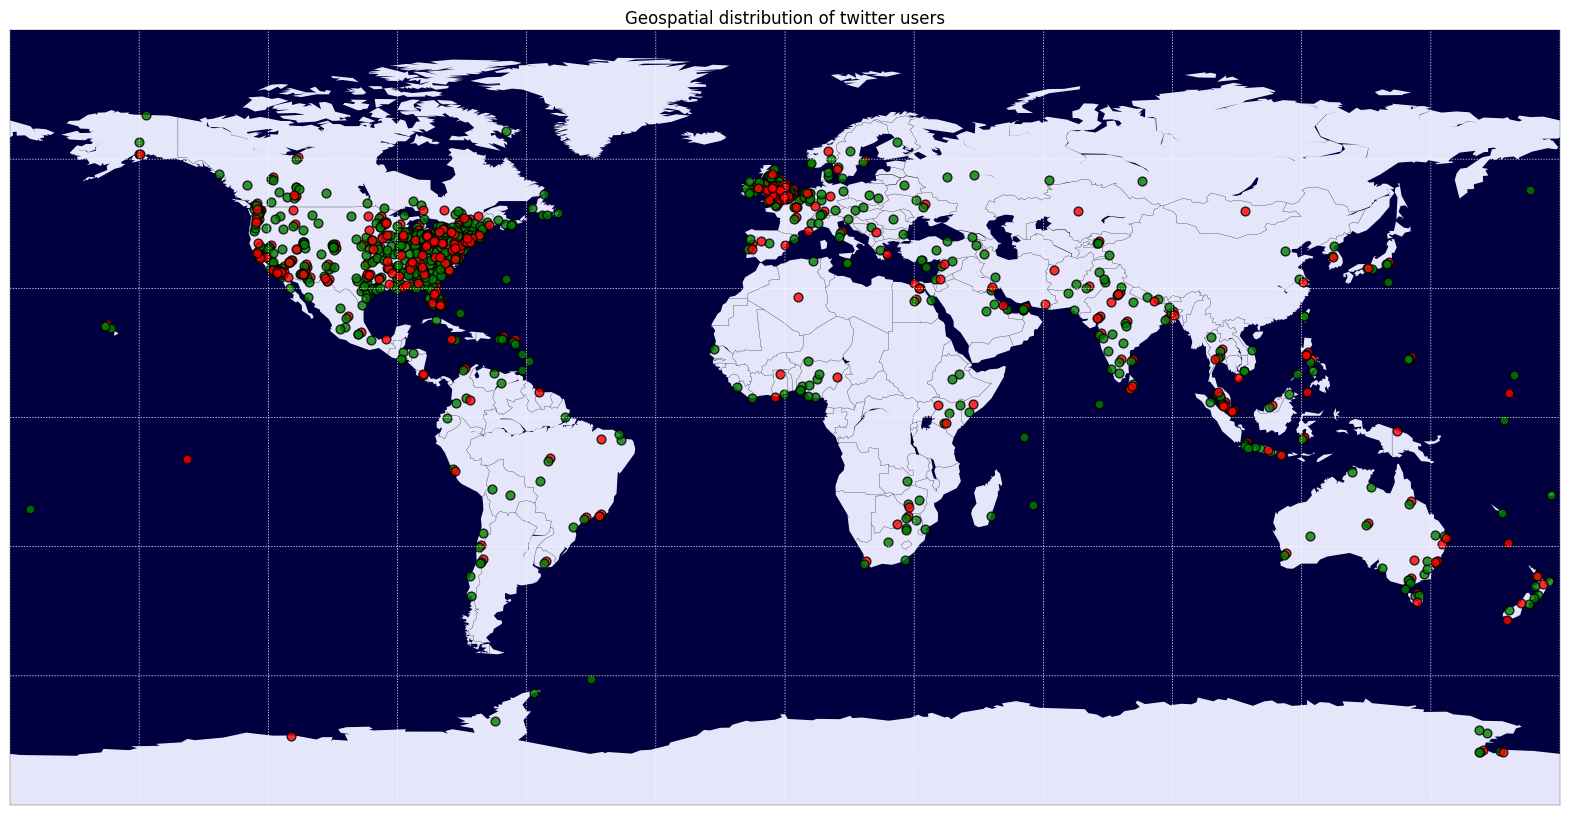

In [330]:

pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)

m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')

m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

#?m.scatter(x=30, y=0, s=40, c='red', zorder=2)

def plot_points_on_map(df_full):
    
    #Plot points on the map. Be creative.
    
    # your code here
    all_pos_users = df_full[df_full['cls'] == 1]
    all_neg_users = df_full[df_full['cls'] == 0]
    pos_lat = [float(i) for i in all_pos_users['lat'][all_pos_users['lat'].notnull()]]
    pos_lon = [float(i) for i in all_pos_users['lon'][all_pos_users['lon'].notnull()]]
    neg_lat = [float(i) for i in all_neg_users['lat'][all_neg_users['lat'].notnull()]]
    neg_lon = [float(i) for i in all_neg_users['lon'][all_neg_users['lon'].notnull()]]
    #print len(neg_lat), len(neg_lon)
    neg_set=set()
    pos_set=set()
    
    for i in xrange(len(pos_lat)):
        pos_set.add((pos_lat[i], pos_lon[i]))
    for i in xrange(len(neg_lat)):
        neg_set.add((neg_lat[i], neg_lon[i]))
    minlen = min(len(neg_lat), len(pos_lat))
    maxlen = max(len(neg_lat), len(pos_lat))
    
    intersect = pos_set.intersection(neg_set)
    subpos = pos_set.difference(intersect)
    subneg = neg_set.difference(intersect)
    #при пересечении сдвигаем только отрицательных пользователей
    for i in intersect:
        m.scatter(i[0]+0.5,i[1]+0.5, s=40, c='red', zorder=2, alpha=0.8)
        m.scatter(i[0], i[1], s=40, c='green', zorder=2, alpha = 0.8)
    #сперва ставим оставшихся положительных пользователей
    for i in subpos:
        m.scatter(i[0], i[1], s=40, c='green', zorder=2, alpha = 0.8)
    #потом - отрицательных
    for i in subneg:
        m.scatter(i[0], i[1], s=40, c='red', zorder=2, alpha = 0.8)
    return

%time plot_points_on_map(df_full)


pl.title("Geospatial distribution of twitter users")
pl.legend()

pl.show()


In [118]:
?m.scatter()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Если координаты накладываются, то точки координаты положительных пользователей ставятся на своё место, а отрицательных - сдвигаются на 0.5 градусов к северу и 0.5 градусов к востоку
* Так как координат положительных пользователей больше, то мы сперва выводим точки, соответствующие положительным пользователям, а затем - отрицательным. Так мы можем выделить скопления отрицательных пользователей на фоне положительных.

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

In [ ]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):

        #Calculate min max and median. Plot histogram
        #Your code here
    lst_pos = [int(i) for i in (map(lambda dt: dt if pd.notnull(dt) else 0, users_wth_pos_class["followers_count"]))]
    lst_neg = [int(i) for i in (map(lambda dt: dt if pd.notnull(dt) else 0, users_wth_neg_class["followers_count"]))]
    lst_pos = sorted(lst_pos)
    lst_neg = sorted(lst_neg)
    max_pos, min_pos, med_pos = lst_pos[-1], lst_pos[0], lst_pos[sample_number / 2]
    max_neg, min_neg, med_neg = lst_neg[-1], lst_neg[0], lst_neg[sample_number / 2]
    mean_pos, mean_neg = sum(lst_pos)/len(lst_pos), sum(lst_neg)/len(lst_neg)
    return lst_pos, lst_neg
lst_pos, lst_neg = descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)
# Compute the distribution of the target variable


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [331]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",-82.70343,27.74836,United States,2010-10,1050,1961,9481,21323,27
1,1392518336,0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,103.5269,1.5486,Malaysia,2013-04,1196,836,19288,7182,110
2,361208576,1,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",-2.23743,53.48095,United Kingdom,2011-08,633,577,7851,1141,28
3,1535215357,1,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,None,None,None,2013-06,2367,2436,187956,88057,68
4,4396196375,1,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awareness...,False,God is my refuge; gem❤️,None,None,None,2015-12,1252,970,36787,26993,75
